# Comparing the different Models

In this notebook we comapre the saved models on Eval data. We do this, so we can have an intermediate look at the results, without using the eval data, so we don't overfit (subconciously) on the eval data

In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f581ee4c250>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
imgs = torch.load('/share/data_ultraschall/nicke_ma/data/test_frames.pth')
segs = torch.load('/share/data_ultraschall/nicke_ma/data/test_segs.pth')

#define a training split 
torch.manual_seed(42)

126 train examples
7 test examples


In [357]:
def eval_pdd(model):
    model.eval()
    overall_dice = torch.zeros(imgs.shape[0], 2)
    unwarped_dice = torch.zeros(imgs.shape[0], 2)
    
    for i,idx in enumerate(range(imgs.shape[0])):
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].contiguous()
        moving_seg = segs[idx:idx+1,1,:].contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
       
        with torch.no_grad():
            fixed_feat = model(fixed.cuda())
            moving_feat = model(moving.cuda())

        ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
        #regularise using meanfield inference with approx. min-convolutions
        soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
        #upsample field to original resolution
        dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


        #apply and evaluate transformation
        identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
        warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

        d1 = dice_coeff(warped_student_seg.squeeze(),fixed_seg,3)
        d2 = dice_coeff(moving_seg,fixed_seg, 3)

        overall_dice[i] = d1
        unwarped_dice[i] = d2
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    return overall_dice.mean(axis=0), unwarped_dice.mean(axis=0)

def eval_flownet(model):
    scale=4
    model.eval()
    overall_dice = torch.zeros(imgs.shape[0], 2)
    unwarped_dice = torch.zeros(imgs.shape[0], 2)
    
    for i,idx in enumerate(range(imgs.shape[0])):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].contiguous()
        moving_seg = segs[idx:idx+1,1,:].contiguous()
        
        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
        
        teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
        teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')
        # Generate the teacher flow estimation
        flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()
        
        with torch.no_grad():
            flownet_flow = model(flow_in)
        
        
        flownet_flow = F.interpolate(flownet_flow.cpu(), size=(H,W), mode='bicubic')

        # warp segmentation with flownet flow
        warped_flownet_seg = warp_seg(moving_seg, flownet_flow)

            
        d1 = dice_coeff(warped_flownet_seg.squeeze(),fixed_seg,3)
        d2 = dice_coeff(moving_seg, fixed_seg, 3)

        overall_dice[i] = d1
        unwarped_dice[i] = d2
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    return overall_dice.mean(axis=0), unwarped_dice.mean(axis=0)

def eval_pwcnet(model):
    scale=1
    model.eval()
    overall_dice = torch.zeros(imgs.shape[0], 2)
    unwarped_dice = torch.zeros(imgs.shape[0], 2)
    
    for i,idx in enumerate(range(imgs.shape[0])):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].contiguous()
        moving_seg = segs[idx:idx+1,1,:].contiguous()
        
        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2
        
        teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
        teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')
        # Generate the teacher flow estimation
        pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()
        
        
        with torch.no_grad():
            pwc_flow = model(pwc_flow_in)
            pwc_flow = pwc_flow[0] * 20.0
            pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W))

        # warp the segmentations with pwc flow
        warped_pwc_seg = warp(moving_seg.float().unsqueeze(0).cuda(), pwc_flow.cuda()).cpu()

        d1 = dice_coeff(warped_pwc_seg.squeeze(),fixed_seg,3)
        d2 = dice_coeff(moving_seg, fixed_seg,3)

        overall_dice[i] = d1
        unwarped_dice[i] = d2
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    return overall_dice.mean(axis=0), unwarped_dice.mean(axis=0)

def eval_baseline():
    baseline = cv2.optflow.DualTVL1OpticalFlow_create()
    overall_dice = torch.zeros(imgs.shape[0], 2)
    unwarped_dice = torch.zeros(imgs.shape[0], 2)
    
    for i,idx in enumerate(range(imgs.shape[0])):
        fixed = imgs[idx:idx+1,0,:].squeeze().float()
        moving = imgs[idx:idx+1,1,:].squeeze().float()

        fixed_seg = segs[idx:idx+1,0,:].contiguous()
        moving_seg = segs[idx:idx+1,1,:].contiguous()

        if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
        if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
            moving_seg = moving_seg*2

        flow_numpy = baseline.calc(fixed.numpy().astype(np.float32), moving.numpy().astype(np.float32), None)
        flow = torch.from_numpy(flow_numpy) * 0.001
        
        warped = warp(moving_seg.float().unsqueeze(0).cuda(), flow.reshape(2,150,150).unsqueeze(0).cuda()).cpu()
        
        d1 = dice_coeff(warped,fixed_seg, 3)
        d2 = dice_coeff(moving_seg,fixed_seg, 3)
        
        overall_dice[i] = d1
        unwarped_dice[i] = d2
    return overall_dice.mean(axis=0), unwarped_dice.mean(axis=0)

# Loading Models

In [4]:
https://www.google.com/maps/place/Studio+-+Kino/@53.5602838,9.9581096,14.42z/data=!4m5!3m4!1s0x47b18f68bddfd8c7:0xd8fd3a644241fd08!8m2!3d53.5572767!4d9.9583775W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()

disp_hw = 5
displace_range = 11

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features


    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [5]:
obel_solo = OBELISK2d(16)
obel_solo.load_state_dict(torch.load("models/Experiment_1/obel16_07_10_21-14-26.pth"))

obel_ensemble = OBELISK2d(16)
obel_ensemble.load_state_dict(torch.load("models/Experiment_2/obel16_ensemble_07_10_21-20-08.pth"))

obel_flow = OBELISK2d(16)
obel_flow.load_state_dict(torch.load("models/Experiment_2/obel16_flownet_teacher_07_10_21-17-22.pth"))

obel_pwc = OBELISK2d(16)
obel_pwc.load_state_dict(torch.load("models/Experiment_2/obel16_pwc_teacher_07_10_21-18-18.pth"))

<All keys matched successfully>

In [266]:
flownet = load_flownet2().cuda()
flownet.eval()

pwc = load_pwcnet().cuda()
pwc.eval()

PWCDCNet(
  (conv1a): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)

In [358]:
print("obel Solo")
print(eval_pdd(obel_solo.cuda()))

print("Ensemble")
print(eval_pdd(obel_ensemble.cuda()))

print("Only Flownet")
print(eval_pdd(obel_flow.cuda()))

print("Only PWC")
print(eval_pdd(obel_pwc.cuda()))

obel Solo
(tensor([0.6794, 0.5768]), tensor([0.6261, 0.5225]))
Ensemble
(tensor([0.6659, 0.5733]), tensor([0.6261, 0.5225]))
Only Flownet
(tensor([0.6684, 0.5716]), tensor([0.6261, 0.5225]))
Only PWC
(tensor([0.6586, 0.5639]), tensor([0.6261, 0.5225]))


In [359]:
eval_flownet(flownet)

(tensor([0.6176, 0.5181]), tensor([0.6261, 0.5225]))

In [360]:
eval_pwcnet(pwc)

(tensor([0.6309, 0.5377]), tensor([0.6261, 0.5225]))

In [361]:
eval_baseline()

(tensor([0.6016, 0.5068]), tensor([0.6261, 0.5225]))

In [353]:
scale=1
idx = 100
fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

fixed_seg = segs[idx:idx+1,0,:].contiguous()
moving_seg = segs[idx:idx+1,1,:].contiguous()

if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
    moving_seg = moving_seg*2

teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')
# Generate the teacher flow estimation
pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()

pwc_flow = pwc(pwc_flow_in)
pwc_flow = pwc_flow[0] * 25.0

pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W), mode='bicubic')
# warp the segmentations with pwc flow
warped_pwc_seg = warp(moving_seg.float().unsqueeze(0).cuda(), pwc_flow.cuda()).cpu()


d1 = dice_coeff(warped_pwc_seg.squeeze(),fixed_seg,3)
d2 = dice_coeff(moving_seg,fixed_seg,3)
print(d1)
print(d2)

tensor([0.9223, 0.9423])
tensor([0.9005, 0.9361])


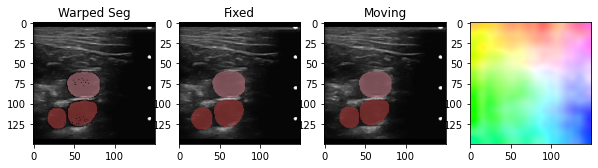

In [354]:
fix,ax = plt.subplots(1,4, figsize=(10,10))
ax[0].imshow(overlaySegment(fixed.squeeze(), warped_pwc_seg.squeeze()))
ax[0].set_title('Warped Seg')
ax[1].imshow(overlaySegment(fixed.squeeze(), fixed_seg.squeeze()))
ax[1].set_title('Fixed')
ax[2].imshow(overlaySegment(moving.squeeze(), moving_seg.squeeze()))
ax[2].set_title('Moving')
ax[3].imshow(showFlow(pwc_flow.detach().cpu()))

plt.show()

In [349]:
scale=1
idx = 12
fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

fixed_seg = segs[idx:idx+1,0,:].contiguous()
moving_seg = segs[idx:idx+1,1,:].contiguous()

if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 1:
    moving_seg = moving_seg*2

teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')
# Generate the teacher flow estimation
flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()

with torch.no_grad():
    flownet_flow = flownet(flow_in)
flownet_flow = F.interpolate(flownet_flow.cpu(), size=(H,W), mode='bicubic')

# warp segmentation with flownet flow
warped_flownet_seg = warp(moving_seg.float().unsqueeze(0).cuda(), flownet_flow.cuda()).cpu()
#warped_flownet_seg = F.grid_sample(moving_seg.unsqueeze(0).float(), flownet_flow.view(1,150,150,2))
d1 = dice_coeff(fixed_seg,warped_flownet_seg.squeeze().cpu(),3)
d2 = dice_coeff(fixed_seg,moving_seg.cpu(),3)
print(d1)
print(d2)

tensor([0.9044, 0.8658])
tensor([0.9671, 0.8812])


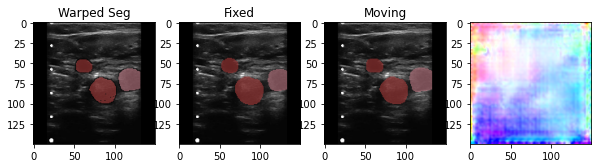

In [350]:
fix,ax = plt.subplots(1,4, figsize=(10,10))
ax[0].imshow(overlaySegment(fixed.squeeze(), warped_flownet_seg.squeeze()))
ax[0].set_title('Warped Seg')
ax[1].imshow(overlaySegment(fixed.squeeze(), fixed_seg.squeeze()))
ax[1].set_title('Fixed')
ax[2].imshow(overlaySegment(moving.squeeze(), moving_seg.squeeze()))
ax[2].set_title('Moving')
ax[3].imshow(showFlow(flownet_flow.flip(1).cpu()))
plt.show()

# Plots to show

Dice of warped: tensor([0.8984]) vs unwarped dice: tensor([0.5779])


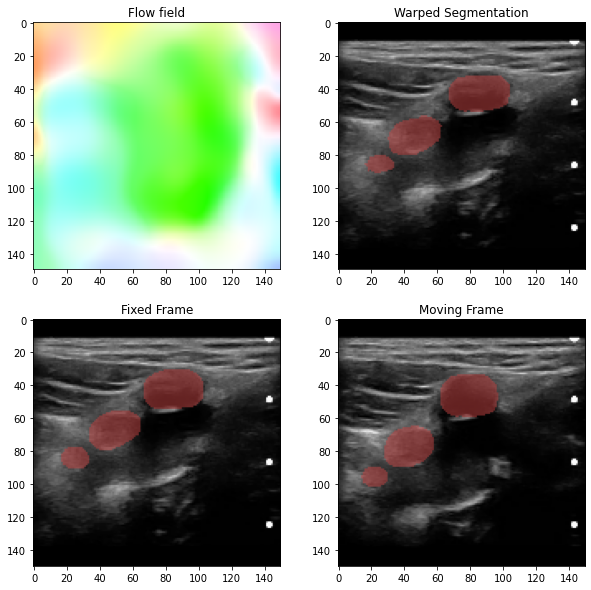

In [25]:
obel_solo.eval()
rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()


with torch.no_grad():
    fixed_feat = obel_solo(fixed.cuda())
    moving_feat = obel_solo(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
d0 = dice_coeff(fixed_seg,moving_seg,2)
print(f"Dice of warped: {d1} vs unwarped dice: {d0}")

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.title("Flow field")
plt.subplot(222)
plt.imshow(overlay)
plt.title("Warped Segmentation")

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.title("Fixed Frame")
plt.subplot(224)
plt.title("Moving Frame")
plt.imshow(overlay_moving)